In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yt
import yt.units as u
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.interpolate import splev, splrep, interp1d, splint

In [18]:
raw_0890, raw50_0890, raw114_0890 = np.load('data/m1.0_p10_b0.8_90.npz'), np.load(
    'data/m1.0_p10_b0.8_P50_90.npz'), np.load('data/m1.0_p10_b0.8_P110_90.npz')

In [92]:
raw_190, raw114_190, raw_190_peri, raw114_190_peri = np.load(
    'data/m1.0_p10_b1.0_90.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_90.npz'), np.load(
            'data/m1.0_p10_b1.0_peri_90.npz'), np.load(
                'data/m1.0_p10_b1.0_P110_peri_90.npz')

In [21]:
rawe_190 = np.load('data/m1.0_p10_b1.0_e9_90.npz')
rawe_0690 = np.load('data/m1.0_p10_b0.6_e9_90.npz')
rawe_0890 = np.load('data/m1.0_p10_b0.8_e9_90.npz')

In [66]:
def combine(raw, raw_peri):
    x_peri, E_peri = raw_peri['x'], raw_peri['y']
    xmin = np.argmin(x_peri)
    x_peri, E_peri = x_peri[xmin:], E_peri[xmin:]
    x, E = raw['x'], raw['y']
    xmin = np.argmin(x)
    x, E = x[xmin:], E[xmin:]
    E = E[x > x_peri[-1]]
    x = x[x > x_peri[-1]]
    dat = {}
    dat['x'] = np.append(x_peri, x)
    dat['y'] = np.append(E_peri, E)
    return dat

In [154]:
def smooth_evol(raw, ax, label, lens=65):
    x = (raw['x'][:] * u.cm).in_units('Rsun').v
    y = np.log10(raw['y'][:])
    spl = splrep(x, y, s=1e-4, k=5)
    x1 = np.logspace(np.log10(x[0]), np.log10(x[-1]), 100)
    y1 = 10**splev(x1, spl)
    ax.plot(x1, y1, label=label)
    return spl, x[0]

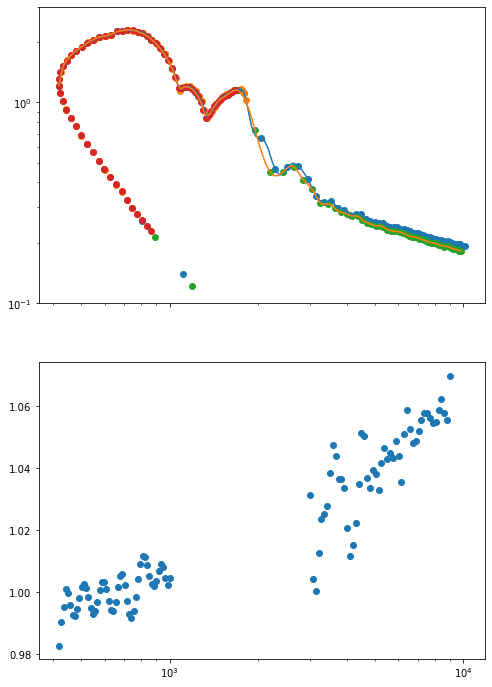

(1.0, 1.1)

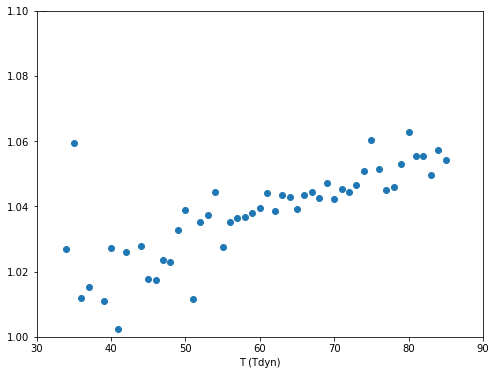

In [174]:
f, ax = plt.subplots(2, 1, figsize=(8, 12), sharex=True)
ax[0].scatter((raw_190['x'] * u.cm).in_units('Rsun'), raw_190['y'])
ax[0].scatter((raw_190_peri['x'] * u.cm).in_units('Rsun'), raw_190_peri['y'])
spl1, xmin = smooth_evol(combine(raw_190, raw_190_peri), ax[0], 'None', lens=60)
ax[0].scatter((raw114_190['x'] * u.cm).in_units('Rsun'), raw114_190['y'])
ax[0].scatter((raw114_190_peri['x'] * u.cm).in_units('Rsun'), raw114_190_peri['y'])
spl2, xmin = smooth_evol(combine(raw114_190, raw114_190_peri), ax[0], 'None', lens=60)
#plt.xlim(300, 1e4)
r = np.append(np.logspace(np.log10(xmin), 3, 50),
              np.logspace(np.log10(3000), np.log10(9000), 50))
ax[1].scatter(r, 10**(splev(r, spl1) - splev(r, spl2)))
ax[0].set_ylim(1e-1, 3)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(raw_190['x']))+20,
            (raw_190['y'] / raw114_190['y']))
plt.xlabel('T (Tdyn)')
plt.xlim(30, 90)
plt.ylim(1, 1.1)

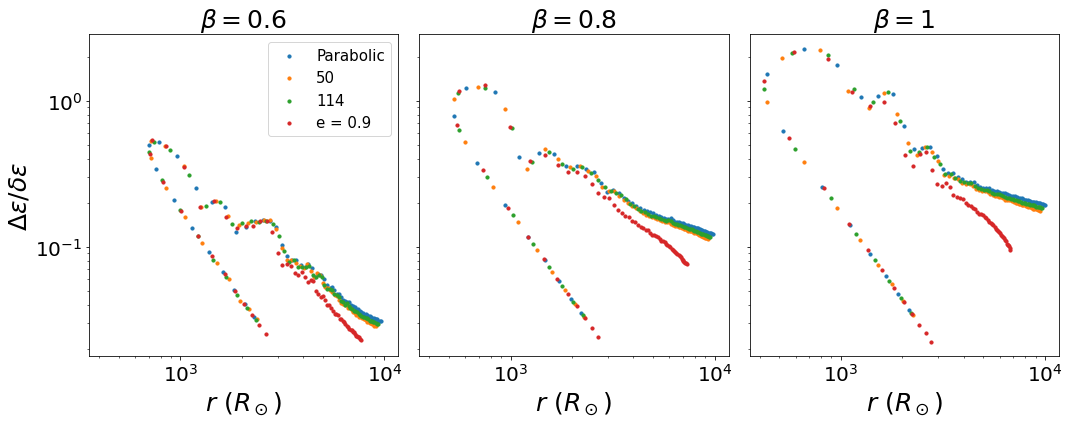

In [21]:
lens = 65
f, ax = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
'''smooth_evol(raw_0690, ax[0], 'Parabolic')
smooth_evol(raw50_0690, ax[0], '50')
smooth_evol(raw114_0690, ax[0], '114')
smooth_evol(rawe_0690, ax[0], 'low e')
smooth_evol(raw_0890, ax[1], 'Parabolic')
smooth_evol(raw50_0890, ax[1], '50')
smooth_evol(raw114_0890, ax[1], '114')
smooth_evol(raw_190, ax[2], 'Parabolic')
smooth_evol(raw50_190, ax[2], '50')
smooth_evol(raw114_190, ax[2], '114')
smooth_evol(rawe_190, ax[2], 'low e')'''
parabolic = [raw_0690, raw_0890, raw_190]
eccl = [raw50_0690, raw50_0890, raw50_190]
ecch = [raw114_0690, raw114_0890, raw114_190]
ecc = [rawe_0690, rawe_0890, rawe_190]
titles = [r'$\beta=0.6$', r'$\beta=0.8$', r'$\beta=1$']
for i in range(3):
    ax[i].scatter((parabolic[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  parabolic[i]['y'][:lens],
                  label='Parabolic',
                  s=10)
    ax[i].scatter((eccl[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  eccl[i]['y'][:lens],
                  label='50',
                  s=10)
    ax[i].scatter((ecch[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  ecch[i]['y'][:lens],
                  label='114',
                  s=10)
    ax[i].scatter((ecc[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  ecc[i]['y'][:lens],
                  label='e = 0.9',
                  s=10)
    ax[i].set_title(titles[i], fontsize=25)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].tick_params(labelsize=20)
    ax[i].set_xlabel(r'$r\ (R_\odot)$', fontsize=25)
ax[0].set_ylabel(r'$\Delta \epsilon/\delta \epsilon$', fontsize=25)
#ax[0].set_ylim(2e-2, 3)
ax[0].legend(fontsize=15)
f.tight_layout()
f.savefig('/Users/chang/Desktop/Energy_Dispersion.png')

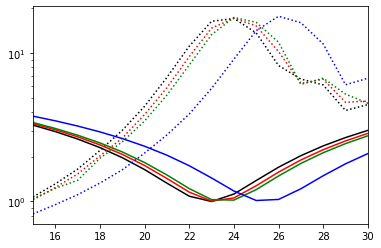

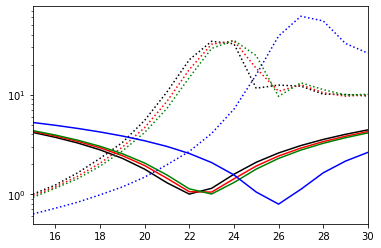

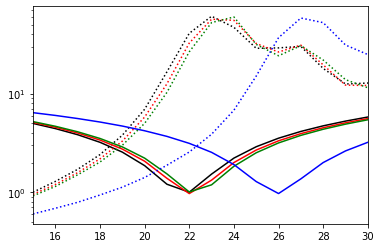

In [145]:
plt.plot(np.arange(25) + 15,
         raw_0690['x'][:25] / raw_0690['x'].min(),
         color='k')
plt.plot(np.arange(25) + 15,
         raw_0690['y'][:25] / raw_0690['y'].min(),
         color='k',
         linestyle=':')
plt.plot(np.arange(25) + 15,
         raw114_0690['x'][:25] / raw_0690['x'].min(),
         color='r')
plt.plot(np.arange(25) + 15,
         raw114_0690['y'][:25] / raw_0690['y'].min(),
         color='r',
         linestyle=':')
plt.plot(np.arange(25) + 15,
         raw50_0690['x'][:25] / raw_0690['x'].min(),
         color='g')
plt.plot(np.arange(25) + 15,
         raw50_0690['y'][:25] / raw_0690['y'].min(),
         color='g',
         linestyle=':')
plt.plot(np.arange(25) + 15,
         rawe_0690['x'][:25] / raw_0690['x'].min(),
         color='b')
plt.plot(np.arange(25) + 15,
         rawe_0690['y'][:25] / raw_0690['y'].min(),
         color='b',
         linestyle=':')
plt.xlim(15, 30)
plt.yscale('log')
plt.show()
plt.plot(np.arange(25) + 15,
         raw_0890['x'][:25] / raw_0890['x'].min(),
         color='k')
plt.plot(np.arange(25) + 15,
         raw_0890['y'][:25] / raw_0890['y'].min(),
         color='k',
         linestyle=':')
plt.plot(np.arange(25) + 15,
         raw114_0890['x'][:25] / raw_0890['x'].min(),
         color='r')
plt.plot(np.arange(25) + 15,
         raw114_0890['y'][:25] / raw_0890['y'].min(),
         color='r',
         linestyle=':')
plt.plot(np.arange(25) + 15,
         raw50_0890['x'][:25] / raw_0890['x'].min(),
         color='g')
plt.plot(np.arange(25) + 15,
         raw50_0890['y'][:25] / raw_0890['y'].min(),
         color='g',
         linestyle=':')
plt.plot(np.arange(25) + 15,
         rawe_0890['x'][:25] / raw_0890['x'].min(),
         color='b')
plt.plot(np.arange(25) + 15,
         rawe_0890['y'][:25] / raw_0890['y'].min(),
         color='b',
         linestyle=':')
plt.xlim(15, 30)
plt.yscale('log')
plt.show()
plt.plot(np.arange(25) + 15, raw_190['x'][:25] / raw_190['x'].min(), color='k')
plt.plot(np.arange(25) + 15,
         raw_190['y'][:25] / raw_190['y'].min(),
         color='k',
         linestyle=':')
plt.plot(np.arange(25) + 15,
         raw114_190['x'][:25] / raw_190['x'].min(),
         color='r')
plt.plot(np.arange(25) + 15,
         raw114_190['y'][:25] / raw_190['y'].min(),
         color='r',
         linestyle=':')
plt.plot(np.arange(25) + 15,
         raw50_190['x'][:25] / raw_190['x'].min(),
         color='g')
plt.plot(np.arange(25) + 15,
         raw50_190['y'][:25] / raw_190['y'].min(),
         color='g',
         linestyle=':')
plt.plot(np.arange(25) + 15,
         rawe_190['x'][:25] / raw_190['x'].min(),
         color='b')
plt.plot(np.arange(25) + 15,
         rawe_190['y'][:25] / raw_190['y'].min(),
         color='b',
         linestyle=':')
plt.xlim(15, 30)
plt.yscale('log')
plt.show()

## Tidal Force Comparison

### Direct Comparison


$$
\begin{align*}
\Delta F_T(t,e)&=\left[\frac{GM}{(r(t,e)-R_*)^2}-\frac{GM}{(r(t,e)+R_*)^2}\right]\\
&\simeq GMr^{-2}(t,e)\cdot \frac{4R_*}{r(t,e)}\\
&=\frac{4GMR_*}{r^3(t,e)}
\end{align*}
$$

In a Keplerian orbit, the radial distance $r$ is related to the eccentric anomaly $E$

$$
r=a(1-e\cos E)
$$

where $E$ satisfies

$$
E - e\sin E=\frac{2\pi (t-t_0)}{P}
$$

so that

$$
\Delta F_T(t,e) = \frac{4GMR_*}{r_p^3}(1-e)^3\xi^{-3}
$$

Here

$$
\quad \xi=\frac ra=1-e\cos E
$$

<ipython-input-12-09e9e1ab4f23>:13: RuntimeWarning: divide by zero encountered in true_divide
  xi = (1 + e) / (1 + e * np.cos(E))  #1 - e * np.cos(E)
<ipython-input-12-09e9e1ab4f23>:13: RuntimeWarning: divide by zero encountered in true_divide
  xi = (1 + e) / (1 + e * np.cos(E))  #1 - e * np.cos(E)
<ipython-input-12-09e9e1ab4f23>:13: RuntimeWarning: divide by zero encountered in true_divide
  xi = (1 + e) / (1 + e * np.cos(E))  #1 - e * np.cos(E)
<ipython-input-12-09e9e1ab4f23>:13: RuntimeWarning: divide by zero encountered in true_divide
  xi = (1 + e) / (1 + e * np.cos(E))  #1 - e * np.cos(E)


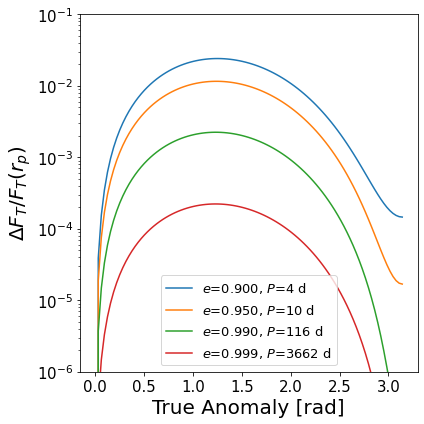

In [12]:
rT = u.Rsun * (7.7e7)**(1 / 3)
P0 = 2 * np.pi * np.sqrt(rT**3 / u.gravitational_constant / 7.7e7 / u.Msun)
def P(e):
    return (P0.in_units('day').v * (1-e)**(-3 / 2))

def FTt(tau, e):
    E = lambda psi: psi - e * np.sin(psi) - 2 * np.pi * tau
    xi = 1 - e * np.cos(fsolve(E, [1]))
    return xi**(-3) * (1 - e)**3


def FT(E, e):
    xi = (1 + e) / (1 + e * np.cos(E))  #1 - e * np.cos(E)
    return xi**(-3)

f, ax = plt.subplots(figsize=(6, 6))
e_arr = np.array([0.90, 0.95, 0.99, 0.999])
tau = np.linspace(0, .5, 100)
E = np.linspace(0, np.pi, 101)
for e in e_arr:
    Fe = (FT(E, e) - FT(E, 1)) / FT(0, 1)
    ax.plot(E, Fe, label=r'$e$={:.3f}, $P$={:.0f} d'.format(e, P(e)))
ax.tick_params(labelsize=15)
ax.set_yscale('log')
ax.set_xlabel(r'True Anomaly [rad]', fontsize=20)
ax.set_ylabel(r'$\Delta F_T/F_T(r_p)$', fontsize=20)
ax.set_ylim(1e-6, 1e-1)
ax.legend(prop={'size': 13})
f.tight_layout()

### Half Period (from Pericenter to Apocenter)

$$
\begin{align*}
\Delta I&=\int_{t(r_\text{min})}^{t(r_\text{max})}\Delta F_T(t,e)\text dt\\
&=4GMR_*\int_{t(r_\text{min})}^{t(r_\text{max})}r^{-3}(t,e)\text dt
\end{align*}
$$

In a Keplerian orbit, the radial distance $r$ is related to the eccentric anomaly $E$

$$
r=a(1-e\cos E)
$$

where $E$ satisfies

$$
E - e\sin E=\frac{2\pi (t-t_0)}{P}
$$

Now we take

$$
t_0=t(r_\text{min})=0,\quad t(r_\text{max})=\frac P2
$$

and define

$$
\tau\equiv\frac tP,\quad F(e)=(1-e)^{3/2}\int_{0}^{1/2}\xi^{-3}(\tau, e)\text d\tau
$$

so that

$$
\Delta I=4GMR_*Pa^{-3}\int_{0}^{1/2}\xi^{-3}(\tau, e)\text d\tau\equiv 8\pi R_*\sqrt{\frac{GM}{r_p^3}}F(e)
$$

and

$$
E-e\sin E=2\pi\tau,\quad \xi=1-e\cos E
$$

In [14]:
from scipy.optimize import fsolve, brentq
from scipy.integrate import simps, quad


def F(e_arr, N=10000):
    res = []
    err = []
    for e in e_arr:

        def xi(tau):
            E = lambda psi: psi - e * np.sin(psi) - 2 * np.pi * tau
            xi = 1 - e * np.cos(fsolve(E, [1]))
            return xi

        f = lambda tau: 1 / xi(tau)**3 * (1 - e)**(3 / 2)

        integral = quad(f, 0, 0.5)
        res.append(integral[0])
        err.append(integral[1])
    return np.array(res), np.array(err)


e_arr = np.linspace(0.9, 0.995, 100)
res, err = F(e_arr, N=100)
res /= res[-1]
e_cri_1 = e_arr[abs(1 - res / res[-1]) <= 0.01][0]
e_cri_5 = e_arr[abs(1 - res / res[-1]) <= 0.05][0]

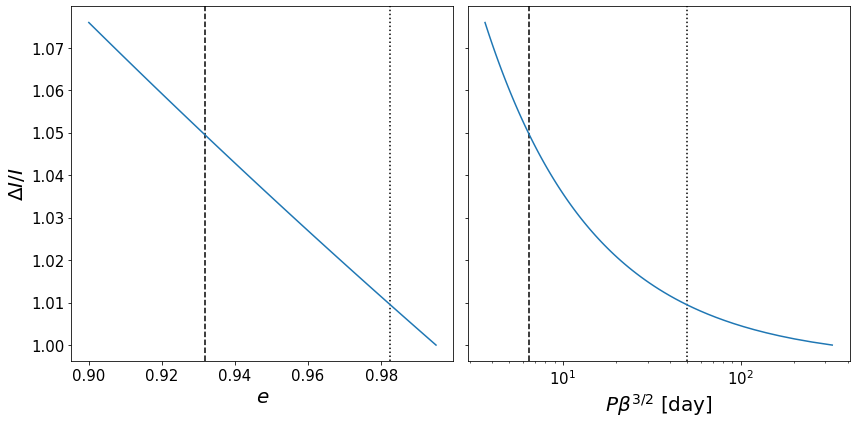

In [15]:
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].errorbar(e_arr, res, yerr=err)
ax[0].axvline(e_cri_1, color='k', linestyle=':')
ax[0].axvline(e_cri_5, color='k', linestyle='--')
ax[0].set_xlabel('$e$', fontsize=20)
ax[0].set_ylabel(r'$\Delta I/I$', fontsize=20)
ax[1].errorbar(P(e_arr), res, yerr=err)
ax[1].axvline(P(e_cri_1), color='k', linestyle=':')
ax[1].axvline(P(e_cri_5), color='k', linestyle='--')
ax[1].set_xlabel(r'$P\beta^{3/2}$ [day]', fontsize=20)
ax[1].set_xscale('log')
for a in ax:
    a.tick_params(labelsize=15)
f.tight_layout()

In [16]:
e_cri_1, e_cri_5

(0.9825252525252526, 0.9316666666666666)

### $\beta$ Decreases by a Factor of 10

$$
\Delta I_{10}=4GMR_*\int_{t(r_p)}^{t(10r_p)}r^{-3}(t,e)\text dt
$$

In [11]:
def F10(e_arr, N=1000):
    res = []
    err = []
    factor = 10
    for e in e_arr:

        def xi(tau):
            E = lambda psi: psi - e * np.sin(psi) - 2 * np.pi * tau
            xi = 1 - e * np.cos(fsolve(E, [1]))
            return xi

        f = lambda tau: 1 / xi(tau)**3 * (1 - e)**(3 / 2)

        def tau_cri(xi0, factor=10):
            y = lambda tau: xi(tau) - factor * xi0
            return brentq(y, 0, 0.5)
        tauc = tau_cri(xi0=xi(0), factor=factor)
        integral = quad(f, 0, tauc)
        res.append(integral[0])
        err.append(integral[1])
    return np.array(res), np.array(err)


e_arr = np.linspace(0.9, 0.995, 100)
res10, err10 = F10(e_arr, N=100)
res10 /= res10[-1]
e10_cri_1 = e_arr[abs(1 - res10 / res10[-1]) <= 0.01][0]
e10_cri_5 = e_arr[abs(1 - res10 / res10[-1]) <= 0.05][0]

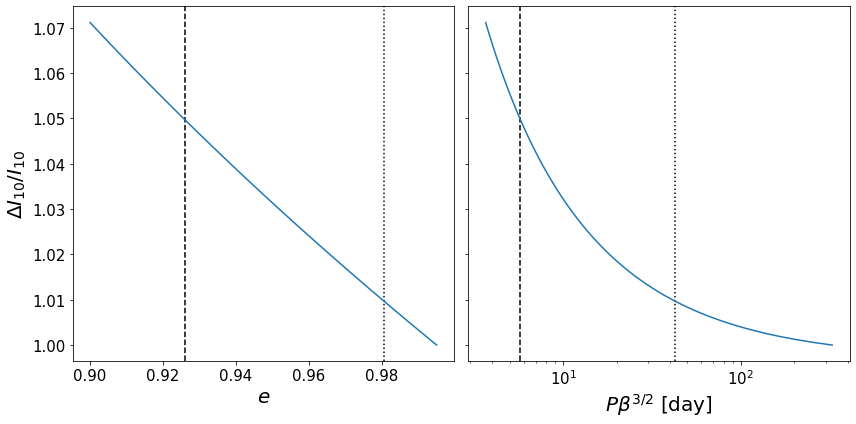

In [12]:
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].errorbar(e_arr, res10, yerr=err)
ax[0].axvline(e10_cri_1, color='k', linestyle=':')
ax[0].axvline(e10_cri_5, color='k', linestyle='--')
ax[0].set_xlabel('$e$', fontsize=20)
ax[0].set_ylabel(r'$\Delta I_{10}/I_{10}$', fontsize=20)
ax[1].errorbar(P(e_arr), res10, yerr=err)
ax[1].axvline(P(e10_cri_1), color='k', linestyle=':')
ax[1].axvline(P(e10_cri_5), color='k', linestyle='--')
ax[1].set_xlabel(r'$P\beta^{3/2}$ [day]', fontsize=20)
ax[1].set_xscale('log')
for a in ax:
    a.tick_params(labelsize=15)
f.tight_layout()

## Critical $e$ for Eccentric TDEs

$$
e_\text{crit}=1-2\frac{q^{-1/3}}{\beta}
$$

$$
q\sim 7\times10^{7}\Rightarrow e_\text{crit}\sim 1-\frac{0.00485}{\beta}\simeq 0.995
$$

In [13]:
P(1-0.00485/0.8), P(1-0.00485)

(245.2928541675975, 342.80718519605193)